# Data cleaning for *Antirrhinum majus* data set from 2012

In [1]:
import numpy as np
from pandas import DataFrame as df
import faps as fp
import matplotlib.pyplot as plt
%pylab inline

print("Created using FAPS version {}.".format(fp.__version__))

ModuleNotFoundError: No module named 'faps.summarise_paternity'

Tom Ellis, June 2017

In this notebook we will examine an empirical dataset using the snapdragon *Antirrhinum majus*.

In 2012 we collected open-pollinated seed capsules from wild mothers and genotypes samples of the offsping. A single seed capsule contains up to several hundred seeds from between 1 and lots of pollen donors. We also collected tissue and GPS positions for as many of the adults reproductive plants as we could find.

These data are those desribed and analysed by Ellis *et al.* (2018), and are available from the [IST Austria data repository](https://datarep.app.ist.ac.at/id/eprint/95) (DOI:10.15479/AT:ISTA:95). 

Below, we will do an initial data inspection to weed out dubious loci and individuals. It can be argued that this process was overly conservative, and we threw out a lot of useful data, so you need not necessarily be so critical of your own data.

## Data inspection

Import genotype data for the reproductive adults and offspring. The latter includes information on the ID of the maternal mother.

In [3]:
progeny = fp.read_genotypes('../../data/offspring_SNPs_2012.csv', mothers_col=1, genotype_col=2)
adults  = fp.read_genotypes('../../data/parents_SNPs_2012.csv')

iix = [i in adults.names for i in progeny.mothers.tolist()]
progeny = progeny.subset(iix)

### Genotype information

As a sanity check, confirm that the marker names really do match.

In [4]:
all([progeny.markers[i] == adults.markers[i] for i in range(progeny.nloci)])

True

Tissue from the adults and progeny was dried in different ways. For the progeny, I didnt use enough silica gel to dry the tissue rapidly, and the DNA became degraded. Reflecting this, although genotype dropouts (the rate at which genotype information at a single locus fails to amplify) is respectable for the adults, but dire for the offspring.

In [5]:
print(
    "Adults:",    adults.missing_data().max(),
    "\nProgeny:", progeny.missing_data().max()
)


Adults: 0.6370056497175142 
Progeny: 0.7863187588152327


Luckily a lot of this is driven by a small number of loci/individuals with very high dropout rates.

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=0.2, hspace=0.2)

mdo = fig.add_subplot(2,2,1)
mdo.hist(progeny.missing_data('marker'), bins=np.arange(0, 1, 0.05))
mdo.set_xlabel("Missing data")
mdo.set_ylabel("Number of loci")
mdo.set_title('Per locus: offspring')

indo = fig.add_subplot(2,2,2)
indo.hist(progeny.missing_data(by='individual'), bins=np.arange(0, 1, 0.05))
indo.set_xlabel("Missing data")
indo.set_ylabel("Number of loci")
indo.set_title('Per indiviudual: offspring')

mda = fig.add_subplot(2,2,3)
mda.hist(adults.missing_data('marker'), bins=np.arange(0, 1, 0.05))
mda.set_xlabel("Missing data")
mda.set_ylabel("Number of loci")
mda.set_title('Per locus: adults')

inda = fig.add_subplot(2,2,4)
inda.hist(adults.missing_data(by='individual'), bins=np.arange(0, 1, 0.05))
inda.set_xlabel("Missing data")
inda.set_ylabel("Number of loci")
inda.set_title('Per indiviudual: adults')

Although overall per locus drop-out rates are low for the adults, there are some individuals with alarmingly high amounts of missing data. Candidates with very few loci typed can come out as being highly compatible with many offspring, just because there is insufficient information to exclude them.

In [ ]:
print(
    "Adults:",   adults.missing_data(by='individual').max(),
    "\nProgeny:", progeny.missing_data('individual').max()
)

Count, then remove individuals with >5% missing data.

In [ ]:
print(
    "Adults:", len(np.array(adults.names)[adults.missing_data(1) > 0.05]),
    "\nProgeny:", len(np.array(progeny.names)[progeny.missing_data(1) > 0.05])
)
    
adults  = adults.subset(individuals= adults.missing_data(1) < 0.05)
progeny = progeny.subset(    individuals= progeny.missing_data(1) < 0.05)

Histograms look much better. It would still worth removing some of the dubious loci with high drop-out rates though.

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=0.2, hspace=0.2)

mdo = fig.add_subplot(2,2,1)
mdo.hist(progeny.missing_data('marker'), bins=np.arange(0, 0.7, 0.05))
mdo.set_xlabel("Missing data")
mdo.set_ylabel("Number of loci")
mdo.set_title('Per locus: offspring')

indo = fig.add_subplot(2,2,2)
indo.hist(progeny.missing_data(by='individual'), bins=np.arange(0, 0.7, 0.05))
indo.set_xlabel("Missing data")
indo.set_ylabel("Number of loci")
indo.set_title('Per indiviudual: offspring')

mda = fig.add_subplot(2,2,3)
mda.hist(adults.missing_data('marker'), bins=np.arange(0, 0.7, 0.05))
mda.set_xlabel("Missing data")
mda.set_ylabel("Number of loci")
mda.set_title('Per locus: adults')

inda = fig.add_subplot(2,2,4)
inda.hist(adults.missing_data(by='individual'), bins=np.arange(0, 0.7, 0.05))
inda.set_xlabel("Missing data")
inda.set_ylabel("Number of loci")
inda.set_title('Per indiviudual: adults')

Remove the loci with dropouts >10% from both the offspring and adult datasets.

In [ ]:
print(np.array(progeny.markers)[progeny.missing_data(0) >= 0.1])

progeny= progeny.subset(loci= progeny.missing_data(0) < 0.1)
adults = adults.subset(loci = progeny.missing_data(0) < 0.1)

Allele frequency and heterozygosity generally show the convex pattern one would expect. An exception is the locus with allele frequency at around 0.4, but heterozygosity >0.7, which is suspect, and indicative of a possible outlier.

In [ ]:
plt.scatter(adults.allele_freqs(), adults.heterozygosity(0))
plt.xlabel('Allele frequency')
plt.ylabel('Heterozygosity')
plt.show()

Loci with low heterozygosity are not dangerous in themselves; they might contribute some information, albeit little. To be on the safe side, let's remove loci with less than 0.2 heterozygosity, and the errant locus with high heterozygosity.

In [ ]:
print(
    "Heterozygosity > 0.7:", adults.markers[adults.heterozygosity(0) >0.7],
    "\nHeterozygosity < 0.2:", progeny.markers[adults.heterozygosity(0) < 0.2]
)

progeny = progeny.subset(loci= (adults.heterozygosity(0) > 0.2) * (adults.heterozygosity(0) < 0.7))
adults  = adults.subset( loci= (adults.heterozygosity(0) > 0.2) * (adults.heterozygosity(0) < 0.7))

### Summary of genotype data

This leaves us with a dataset of 61 loci for which allele frequency and heterozygosity are highest around 0.5, which is what we would like. In particular, heterozygosity (and hence homozygosity) among the adults is humped around 0.5, which is a good sign that parents should be readily distinguishable. There is nevertheless substantial spread towards zero and one for the progeny data however, which is less than ideal.

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(wspace=0.1, hspace=0.2)

afp = fig.add_subplot(2,2,1)
afp.hist(adults.allele_freqs())
afp.set_title('Adults')
afp.set_xlabel("Allele frequency")

afo = fig.add_subplot(2,2,2)
afo.hist(progeny.allele_freqs())
afo.set_title('Offspring')
afo.set_xlabel("Allele frequency")

hetp = fig.add_subplot(2,2,3)
hetp.hist(adults.heterozygosity(0))
hetp.set_xlabel("Heterozygosity")

heto = fig.add_subplot(2,2,4)
heto.hist(progeny.heterozygosity(0))
heto.set_xlabel("Heterozygosity")

The effective number of loci can be seen as the number of loci at which one can make compare the offspring, maternal and candidate paternal genotype (i.e. those loci with no missing data). Given how high dropouts are in the offspring, it is worthwhile to check the effective number of loci for this dataset.

To calculate the effective number of loci, we need genotype data for the mothers.

In [ ]:
# Check that the mother of each offspring is found in the array of adults,
# and select only those offspring.
ix = [i for i in range(progeny.size) if progeny.mothers[i] in adults.names]
progeny = progeny.subset(ix)
# Genotype data on those adults that are also mothers.
mothers = adults.subset(progeny.parent_index('m', adults.names))

In fact, effective number of loci is good. The minimum number of valid loci to compare is 46, and in 99% of cases there are 57 or more loci.

In [ ]:
neloci  = fp.effective_nloci(progeny, mothers, adults)

plt.hist(neloci.flatten(), bins=np.arange(45.5,63.5,1))
plt.show()

Finally, print some summary statistics about the quality of the genotype information in the data set.

In [ ]:
print(
    "Total n. loci:", adults.nloci,
    "\nMean per-locus missing data in the adults:",  adults.missing_data(by = 'marker').mean(),
    "\nMean per-locus missing data in the progeny:", progeny.missing_data(by = 'marker').mean(),
    "\nMinimum heterozygosity at any locus:", adults.heterozygosity(by = 'marker').min(),
    "\nMaximum heterozygosity at any locus:", adults.heterozygosity(by = 'marker').max(),
    "\nLowest minor-allele frequency:",  adults.allele_freqs().min(),
    "\nHighest minor-allele frequency:", adults.allele_freqs().max()
)

## Example family: L1872

*Note from August 2021: this section includes some old and fairly ugly list comprehensions that aren't the clearest way to do things, which I hope to update at some point. If you want to apply what follows to your own work, perhaps don't worry too much about what they are doing, and just try to see which names you would need to substitute to apply it to your own data.*

The `progeny` dataset consists of offspring from multiple families that were genotyped at the same time. It was convenient to consider them as one so far to tidy up the genotype data, but for subsequent analysis we need to split them up into their constituent full sib families. This is easy to do with `split`, which returns a list of `genotypeArray` objects.

In [ ]:
prlist = progeny.split(progeny.mothers)
len(prlist)

By way of a sanity check we will examine one of the largest families in detail. After the data filtering above, there are 20 offspring from mother L1872. Distributions of missing data, heterozygosity and allele frequency at each locus suggest no reason for alarm.

In [ ]:
ex_progeny = prlist["L1872"]
ex_mother  = adults.subset(ex_progeny.parent_index('m', adults.names))

ex_progeny.size

### Family structure

Cluster the family into sibships. I have set the proportion of missing parents to 0.1; we have removed 140 of the 2219 (6%) candidates logged as alive in 2012, and I allow for 10% of candidates having been missed. In fact the results do not depend on the parameter unless it is unrealistically high.

In [ ]:
allele_freqs = adults.allele_freqs() # population allele frequencies
ex_patlik    = fp.paternity_array(
    ex_progeny,
    ex_mother,
    adults,
    mu = 0.0015,
    missing_parents=0.1
)
ex_sc        = fp.sibship_clustering(ex_patlik, 1000)

We can first look at the dendrogram of relatedness between individuals derived from the array of paternity likleihoods. 

In [ ]:
from scipy.cluster.hierarchy import dendrogram
dendrogram(ex_sc.linkage_matrix, orientation='left', color_threshold=0,
           above_threshold_color='black')
plt.show()

We can compare this to the most-probable partition structure to get a rough idea of what as going on. This partition groups offspring into 6 full sibships and has a posterior probability of 0.74. The partition structure simply labels individuals 0 to 20 with a unique, arbitrary identifier. For example, individuals 2 and 3 are grouped into an especially large family labelled '1'.

In [ ]:
print(
    "Most-probable partition:", ex_sc.mlpartition,
    "\nUnique families:", np.unique(ex_sc.mlpartition),
    "\nPosterior probability of most-probable partition:", np.exp(ex_sc.prob_partitions.max())
)

We can recover posterior probabilties of paternity for each candidate on each offspring using `posterior_paternity_matrix`. For most offspring, there is a single candidate with a probability of paternity close to one.

In [313]:
postpat = ex_sc.posterior_paternity_matrix()

# Add a label for missing fathers to the end of 
adults.names = np.append(adults.names, "missing")
# names of most probable candidates
mx = np.array([np.where(postpat[i].max() == postpat[i])[0][0] for i in range(ex_progeny.size)])

# Print a dataframe summarising this
df([adults.names[mx], np.exp(postpat.max(1))]).T

,0,1
0,M0880,0.79962
1,M0819,1.0
2,M0819,1.0
3,M0698,1.0
4,missing,1.0
5,missing,1.0
6,M0819,1.0
7,missing,1.0
8,missing,1.0
9,M0819,1.0


### Family sizes

Consistent with the results for many families (shown below), the posterior distributions for family size suggest many small families and a smaller number of larger families.

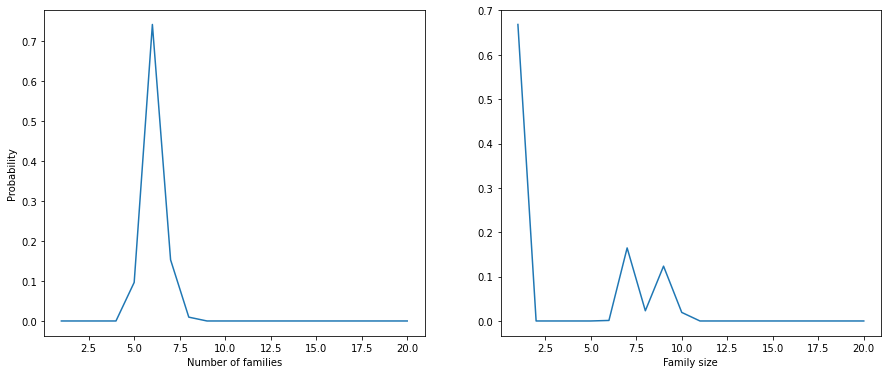

In [314]:
fig = plt.figure(figsize=(15,6))

nf = fig.add_subplot(1,2,1)
nf.plot(range(1,ex_progeny.size+1), ex_sc.nfamilies())
nf.set_xlabel('Number of families')
nf.set_ylabel('Probability')

fs = fig.add_subplot(1,2,2)
fs.plot(range(1,ex_progeny.size+1), ex_sc.family_size())
fs.set_xlabel('Family size')
plt.show()

### Geographic positions

Intuitively, one would expect most pollen donors to be fairly close to the mother. Since the most probable partition had fairly strong support and identified a set of candidates with posterior probabilities close to one, it is reasonable to use these individuals to get an idea of where the pollen donors are to be found.

First, import GPS data and make sure sample IDs match genotype data.

In [315]:
gps_pos = np.genfromtxt('../../data/amajus_GPS_2012.csv', delimiter=',', skip_header=1, usecols=[3,4]) # import CSV file
gps_lab = np.genfromtxt('../../data/amajus_GPS_2012.csv', delimiter=',', skip_header=1, usecols=0, dtype='str') # import CSV file
# subset GPS data to match the genotype data.
ix = [i for i in range(len(gps_lab)) if gps_lab[i] in adults.names]
gps_pos, gps_lab = gps_pos[ix], gps_lab[ix]

In [316]:
ix =[i for i in range(len(gps_lab)) if gps_lab[i] in adults.names[mx]]
gps_cands = gps_pos[ix]
gps_ex =  gps_pos[gps_lab == "L1872"].squeeze()

The map below shows the spatial positions of all individuals in the sample in green. Overlaid are the mother in red, and top candidates in blue. The likley candidates are indeed found close to the mother along the lower (southern-most) road, with two individuals on the upper (northern) road. This gives us no cause to doubt the validity of the paternity results.

In [317]:
second = np.sort(postpat, 1)[:, 1]
sx = np.array([np.where(second[i] == postpat[i])[0][0] for i in range(ex_progeny.size)])
gps_sec = gps_pos[np.unique(sx)]

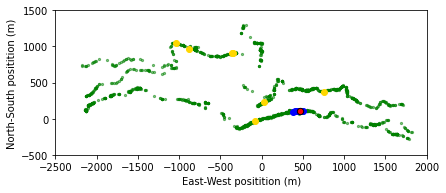

In [318]:
fig = plt.figure(figsize=(16.9/2.54,6.75/2.54))
#plt.figure(figsize=(12.5,5)

plt.xlabel('East-West positition (m)')
plt.ylabel('North-South positition (m)')
plt.xlim(-2500,2000)
plt.ylim(-500,1500)
plt.scatter(gps_pos[:,0],  gps_pos[:,1], s=5, color='green', alpha=0.5)
plt.scatter(gps_sec[:,0],  gps_sec[:,1], color='gold')
plt.scatter(gps_cands[:,0],gps_cands[:,1], color='blue')
plt.scatter(gps_ex[0], gps_ex[1], color='red', s=40, edgecolors='black')
plt.show()

We can use these data to get a very rough dispersal kernal. Most pollen comes from within 50m of the maternal plant.

Mean dispersal of top candidates = 47.73636198050704 metres


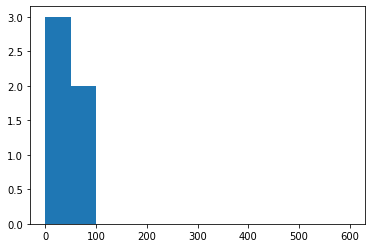

In [319]:
dists = np.sqrt((gps_ex[0] - gps_cands[:,0])**2 + (gps_ex[1] - gps_cands[:,1])**2)
print("Mean dispersal of top candidates =",mean(dists), "metres")

plt.hist(dists, bins=np.arange(0,650,50))
plt.show()

In contrast, the second-most-likely candidates are on average more than 800m from the maternal plant.

In [320]:
dists2 = np.sqrt((gps_ex[0] - gps_sec[:,0])**2 + (gps_ex[1] - gps_sec[:,1])**2)
print("Mean dispersal of second candidates =",mean(dists2), "metres")


Mean dispersal of second candidates = 887.9552522780782 metres


## Multiple families

The code becomes more challenging because we will need to perform operations on every element in this list. Luckily this is straightforward in Python if we use list comprehensions. For example, we can pull out and plot the number of offspring in each half-sibling array:

In [ ]:
plt.hist([prlist[k].size for k in prlist.keys()], bins=np.arange(0,25))
plt.show()

All of these families are samples from much larger half sib arrays, so comparing full-sibship sizes and number is even more difficult if there are different numbers of offspring. For this reason we can pick out only those families with 17 or more offspring.

This cell splits genotype data into maternal families of 17 or more offspring,  then pick 17 offspring at random (there is no meaning in the order of individuals in the `genotypeArray` object, so taking the first 17 is tantamount to choosing at random). This leaves us with 18 familes of 17 offspring.

In [ ]:
# split into maternal families
mlist  = mothers.split(progeny.mothers)
prlist = progeny.split(progeny.mothers)
# families with 20 or more offspring
prog17 = {k : prlist[k] for k in prlist.keys() if prlist[k].size >=17} 
mlist  = {k : mlist[k]  for k in prlist.keys() if prlist[k].size >=17}
# take the first 17 offspring
prog17 = {k : v.subset(range(17)) for k,v in prog17.items()}
mlist  = {k : v.subset(range(17)) for k,v in mlist.items()}

Calculate likelihoods of paternity for each family. This took 3 seconds on a 2010 Macbook Pro; your mileage may vary. In order to do so we also need population allele frequencies, and to remove the entry for missing fathers from the vector of candidate names that we added previously.

In [ ]:
allele_freqs = adults.allele_freqs() # population allele frequencies
adults.names = adults.names[:-1] # Remove 'missing' from candidate names

from time import time
t0=time()
patlik = fp.paternity_array(prog17, mlist, adults, mu=0.0013, missing_parents=0.1)
print("Completed in {} seconds.".format(time() - t0))

The next step is clustering each family into full sibships.

In [ ]:
t1 = time()
sc = fp.sibship_clustering(patlik)
print("Completed in {} seconds.".format(time() - t1))

Calculate probability distributions for family size and number of families for each array.

In [ ]:
nfamilies = [x.nfamilies() for x in sc.values()]
nfamilies = np.array(nfamilies)

famsize = [x.family_size() for x in sc.values()]
famsize = np.array(famsize)

Plots below show the probability distributions for the number and sizes of families. Grey bars show 95% credible intervals (see CDF plots below). Samples of 17 offspring are divided into between four and 16 full-sibling families consisting of between one and eight individuals. Most families seem to be small, with a smaller number of large families.

In [ ]:
fig = plt.figure(figsize=(16.9/2.54, 6/2.54))
fig.subplots_adjust(wspace=0.3, hspace=0.1)

nf = fig.add_subplot(1,2,1)
nf.set_ylabel('Probability density')
nf.set_xlabel('Number of families')
nf.set_ylim(-0.005,0.2)
nf.set_xlim(0,18)
nf.bar(np.arange(0.5,17.5), nfamilies.sum(0)/nfamilies.sum(), color='1', width=1)
nf.bar(np.arange(3.5,16.5), (nfamilies.sum(0)/nfamilies.sum())[3:16], color='0.75', width=1)

fs = fig.add_subplot(1,2,2)
fs.set_xlabel('Family size')
#fs.set_ylabel('Probability density')
fs.set_ylim(-0.05,0.8)
fs.set_xlim(0,17)
fs.bar(np.arange(0.5,17.5), famsize.sum(0)/famsize.sum(), color='1', width=1)
fs.bar(np.arange(0.5,6.5), (famsize.sum(0)/famsize.sum())[:6], color='0.75', width=1)

plt.show()

Cumulative probability density plots demonstrate the credible intervals for family size and number.

In [ ]:
fig = plt.figure(figsize=(15, 6))
fig.subplots_adjust(wspace=0.3, hspace=0.1)

nf = fig.add_subplot(1,2,1)
nf.set_ylabel('Cumulative density')
nf.set_xlabel('Number of families')
nf.set_xlim(0,20)
nf.set_ylim(0,1.05)
nf.plot(np.arange(1,18), np.cumsum(nfamilies.sum(0)/nfamilies.sum()))
nf.axhline(0.975, 0.05, 0.95, linestyle='dashed')
nf.axhline(0.025, 0.05, 0.95, linestyle='dashed')
nf.grid()

fs = fig.add_subplot(1,2,2)
fs.set_ylabel('Cumulative density')
fs.set_xlabel('Family size')
fs.set_xlim(0,21)
fs.set_ylim(0,1.05)
fs.plot(np.arange(1,18), np.cumsum(famsize.sum(0)/famsize.sum()))
fs.axhline(0.975, 0.05, 0.95, linestyle='dashed')
fs.axhline(0.025, 0.05, 0.95, linestyle='dashed')
fs.grid()